In [1]:
# To visualize plots in the notebook
%matplotlib inline

# Imported libraries
import csv
import random
import matplotlib
import matplotlib.pyplot as plt
import pylab
import numpy as np
from pathlib import Path
from tqdm import tqdm
import pandas as pd

%config InlineBackend.figure_format = 'retina' 

In [2]:
# Define the figure size and dpi
fig_width = 6.9  # inches
fig_height = 3.5  # inches
fig_dpi = 300

plt.rcParams.update({
    'figure.figsize': (fig_width, fig_height),
    'figure.dpi': fig_dpi,
    
    # Fonts
    'font.size': 10,
    
    # Axes
    'axes.labelsize': 10,
    'axes.titlesize': 10,
    'axes.linewidth': 0.5,
    'axes.grid': True,
    'grid.linestyle': ':',
    'grid.linewidth': 0.5,
    'grid.color': 'gray',
    
    # Legend
    'legend.fontsize': 8,
    'legend.frameon': True,
    'legend.framealpha': 0.8,
    'legend.fancybox': False,
    'legend.edgecolor': 'gray',
    'legend.facecolor': 'white',
    'legend.borderaxespad': 0.5,
    'legend.borderpad': 0.4,
    'legend.labelspacing': 0.5,
    
    # Lines
   'lines.linewidth': 1.0, # set the default linewidth for plot lines to 1.0 points
   'lines.markersize': 4, # set the default marker size for plot markers to 6 points
    
    'axes.labelsize': 10, # set the font size of the axis labels to 10 points
    'axes.titlesize': 12, # set the font size of the plot title to 12 points
    'xtick.labelsize': 8, # set the font size of the x-axis tick labels to 8 points
    'ytick.labelsize': 8, # set the font size of the y-axis tick labels to 8 points
})

In [3]:
import matplotlib.colors
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#5398E6","#E6695E","#48E4E5",
                                                                "#E6A430","#3CE685","#E6E05A",
                                                                "#8D55E6", "#4F709C"])

In [4]:
def plot_graph(df):
    ax = df.plot(kind='bar', rot=30, width=0.8, colormap=cmap)
    handles, labels = ax.get_legend_handles_labels()
    labels= ['NC Node 1', 'NC Node 2', 'NC Node 3', 'NC Node 4', 'NC Node 5', 'Fed 10', 'Fed 20', 'Fed 50']
    ax.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=4, frameon=True, borderpad=1, labelspacing=1)
    ax.set_ylabel("Average min WMD")

#### Import TMmodel from repo

In [5]:
import sys
sys.path.append('../..')
from src.aux_modules.topicmodeler.src.topicmodeling.manageModels import TMmodel

#### Load Word2Vec model

In [6]:
import gensim.downloader as api
model = api.load('word2vec-google-news-300')

In [7]:
model.init_sims(replace=True)  # Normalizes the vectors in the word2vec class.

/tmp/ipykernel_2038352/3215191999.py:1: DeprecationWarning: Call to deprecated `init_sims` (Use fill_norms() instead. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True)  # Normalizes the vectors in the word2vec class.


#### Get non-collaborative and centralized models

In [8]:
path_models = Path("/export/usuarios_ml4ds/lbartolome/Repos/my_repos/gFedNTM/experiments/collab_vs_non_collab/results/models")

In [9]:
node_models = sorted([el for el in path_models.iterdir() if el.name.startswith('non_collaborativ')], key=lambda el: el.name)
print(node_models)

[PosixPath('/export/usuarios_ml4ds/lbartolome/Repos/my_repos/gFedNTM/experiments/collab_vs_non_collab/results/models/non_collaborative_computer_science_0_20230919'), PosixPath('/export/usuarios_ml4ds/lbartolome/Repos/my_repos/gFedNTM/experiments/collab_vs_non_collab/results/models/non_collaborative_economics_0_20230919'), PosixPath('/export/usuarios_ml4ds/lbartolome/Repos/my_repos/gFedNTM/experiments/collab_vs_non_collab/results/models/non_collaborative_philosophy_0_20230919'), PosixPath('/export/usuarios_ml4ds/lbartolome/Repos/my_repos/gFedNTM/experiments/collab_vs_non_collab/results/models/non_collaborative_political_science_0_20230919'), PosixPath('/export/usuarios_ml4ds/lbartolome/Repos/my_repos/gFedNTM/experiments/collab_vs_non_collab/results/models/non_collaborative_sociology_0_20230919')]


In [10]:
centralized_models = sorted([el for el in path_models.iterdir() if el.name.startswith('centralied')], key=lambda el: el.name)
#centralized_models = centralized_models[0:-1]
print(centralized_models)

[PosixPath('/export/usuarios_ml4ds/lbartolome/Repos/my_repos/gFedNTM/experiments/collab_vs_non_collab/results/models/centralied_10_0_20230919'), PosixPath('/export/usuarios_ml4ds/lbartolome/Repos/my_repos/gFedNTM/experiments/collab_vs_non_collab/results/models/centralied_20_0_20230919'), PosixPath('/export/usuarios_ml4ds/lbartolome/Repos/my_repos/gFedNTM/experiments/collab_vs_non_collab/results/models/centralied_50_0_20230919')]


In [11]:
all_models = node_models + centralized_models

In [12]:
# creating a list of index names
index_values = ['Node ' + str(el+1) for el in range(5)]
# creating a list of column names
column_values = index_values + ['Fed 10', 'Fed 20', 'Fed 30']

#### Topn = 10

In [ ]:
n_words = 10
tfidf = True

distances = np.zeros((len(node_models), len(all_models)))

for idx_ref, ref_model in enumerate(node_models):
    this_topic_dst = []
    ref_topics = [el[1].split(', ') for el in TMmodel(ref_model.joinpath('TMmodel')).get_tpc_word_descriptions(n_words=n_words, tfidf=tfidf)]
    for idx_comp, comp_model in enumerate(all_models):
        comp_topics = [el[1].split(', ') for el in TMmodel(comp_model.joinpath('TMmodel')).get_tpc_word_descriptions(n_words=n_words, tfidf=tfidf)]
        all_dist = np.zeros((len(ref_topics), len(comp_topics)))
        for idx1,tpc1 in enumerate(ref_topics):
            for idx2,tpc2 in enumerate(comp_topics):
                all_dist[idx1,idx2] = model.wmdistance(tpc1[:n_words], tpc2[:n_words])
        distances[idx_ref, idx_comp] = np.mean(np.min(all_dist,axis=1))

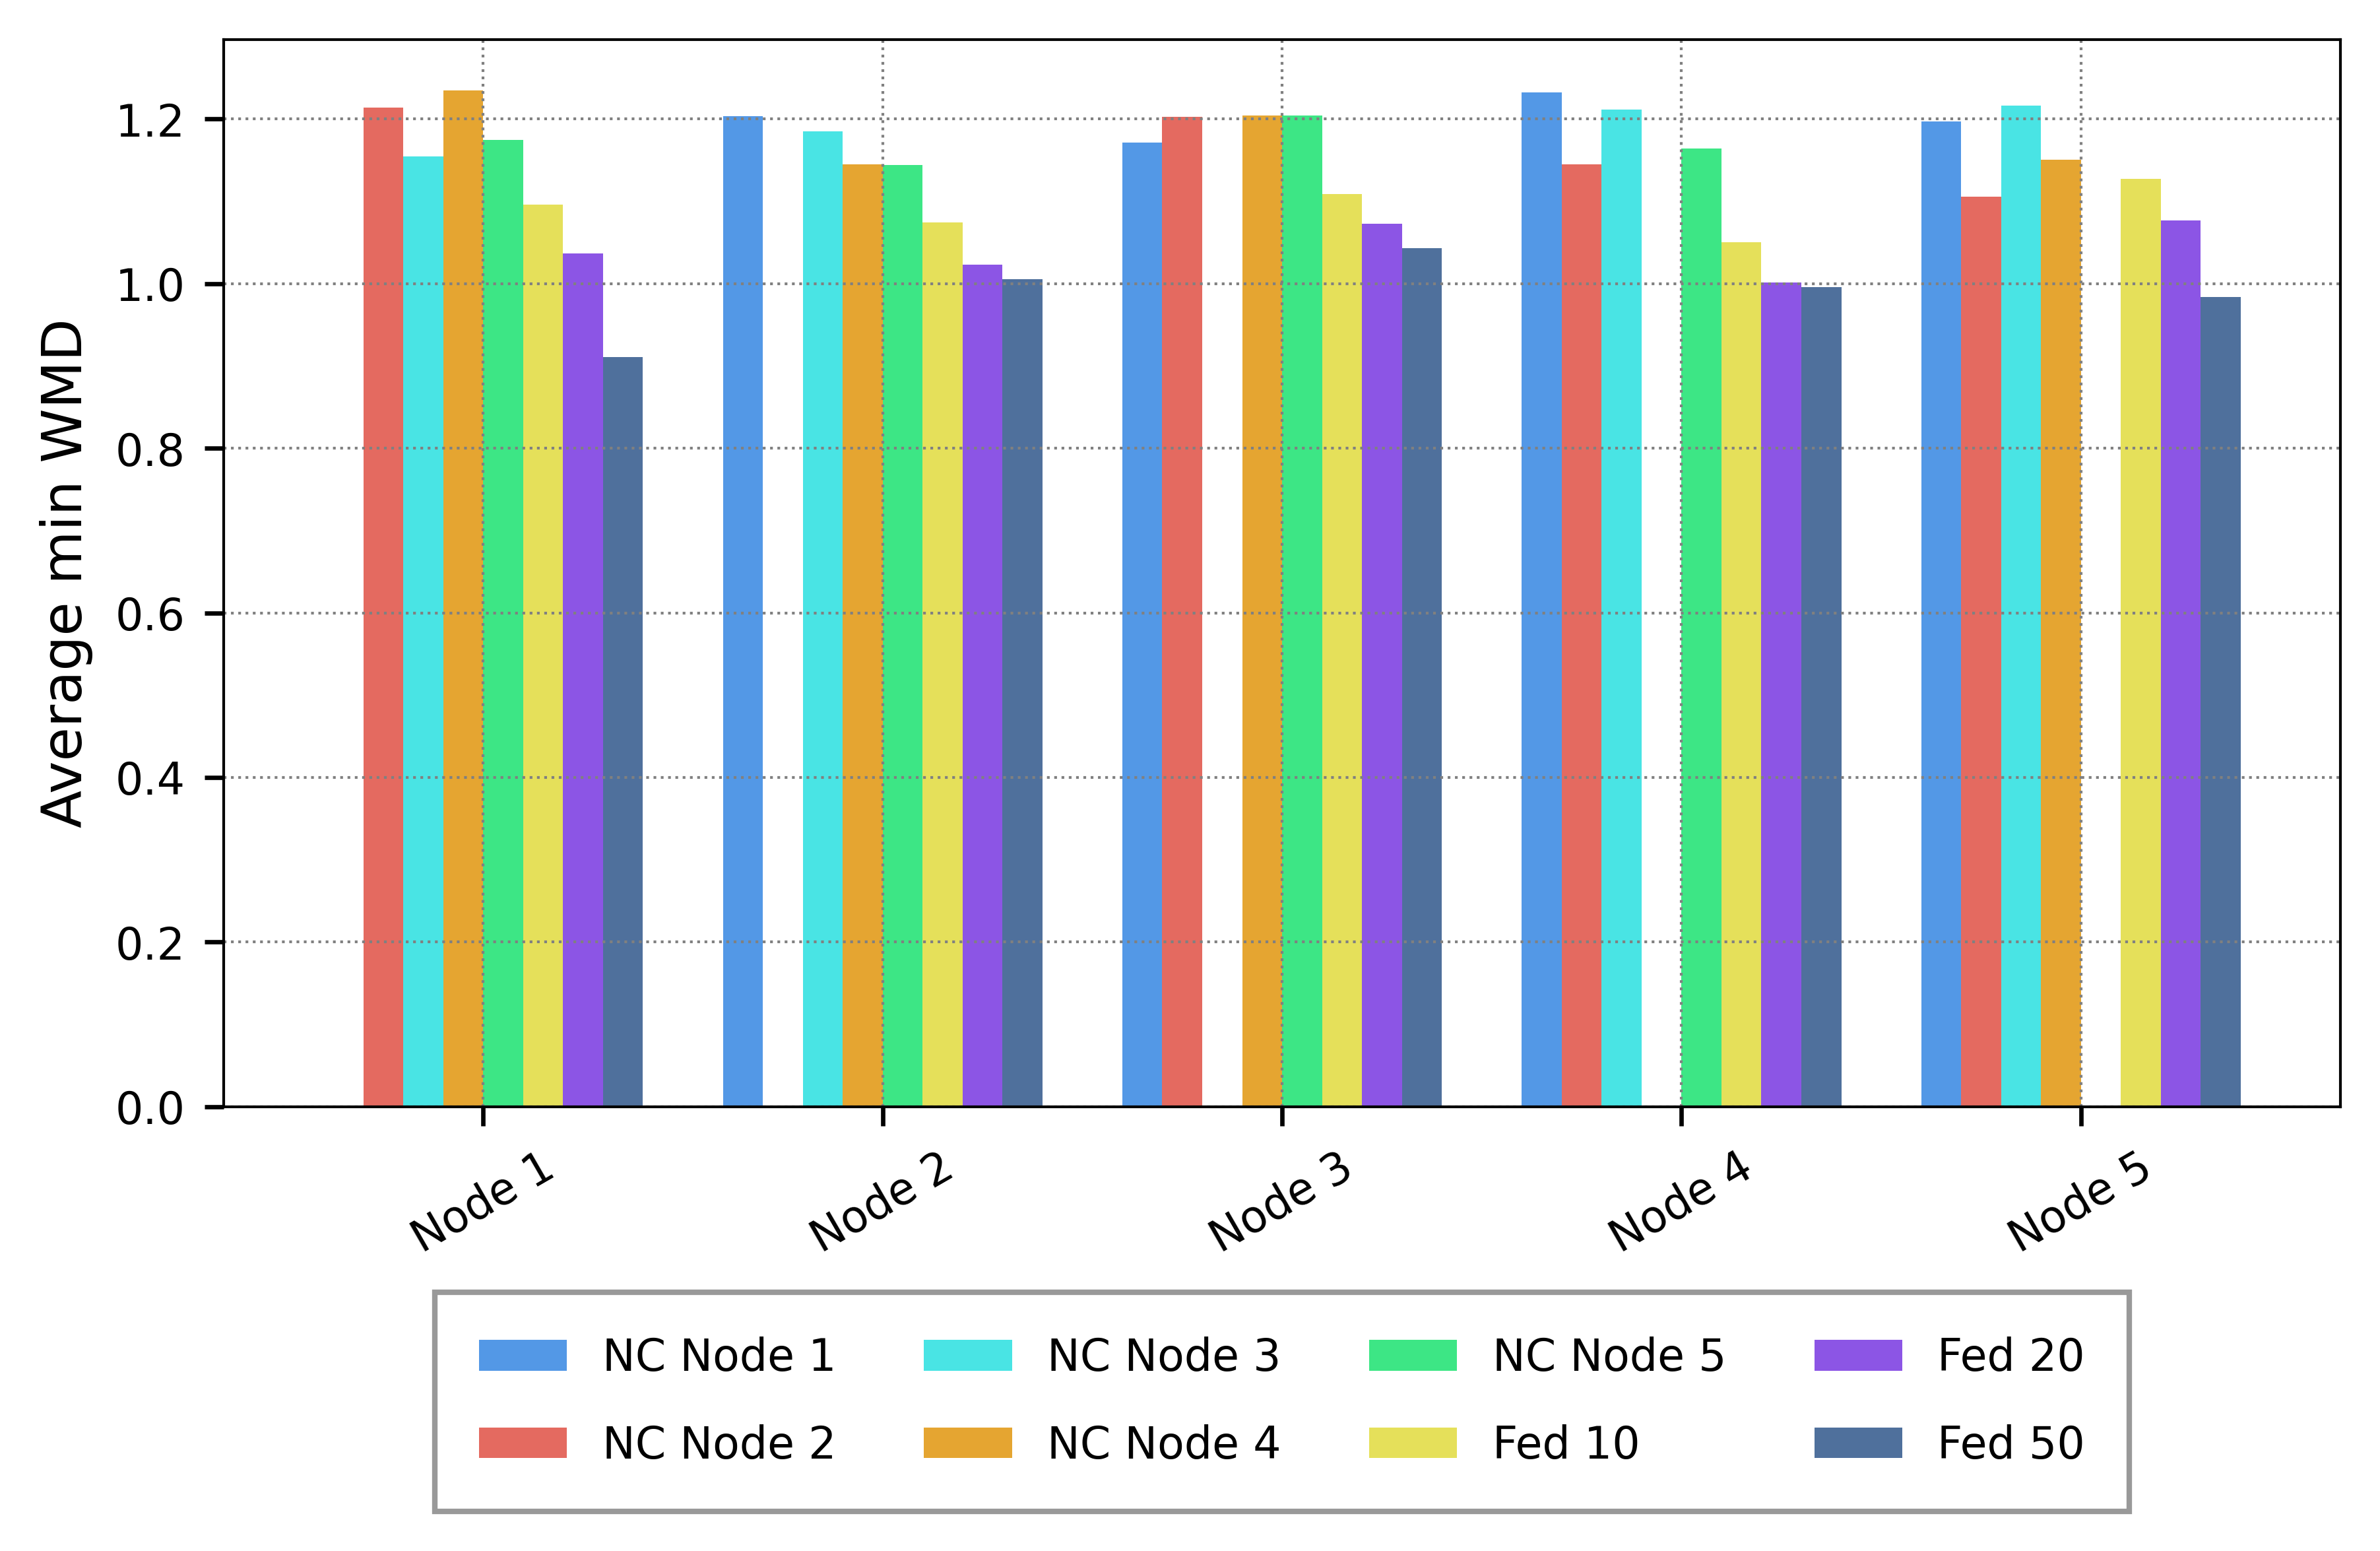

In [14]:
# creating the dataframe
df10 = pd.DataFrame(data = distances, 
                  index = index_values, 
                  columns = column_values)
# plot graph
plot_graph(df10)

#### Topn = 50

In [ ]:
n_words = 50
tfidf = True

distances = np.zeros((len(node_models), len(all_models)))

for idx_ref, ref_model in enumerate(node_models):
    this_topic_dst = []
    ref_topics = [el[1].split(', ') for el in TMmodel(ref_model.joinpath('TMmodel')).get_tpc_word_descriptions(n_words=n_words, tfidf=tfidf)]
    for idx_comp, comp_model in enumerate(all_models):
        comp_topics = [el[1].split(', ') for el in TMmodel(comp_model.joinpath('TMmodel')).get_tpc_word_descriptions(n_words=n_words, tfidf=tfidf)]
        all_dist = np.zeros((len(ref_topics), len(comp_topics)))
        for idx1,tpc1 in enumerate(ref_topics):
            for idx2,tpc2 in enumerate(comp_topics):
                all_dist[idx1,idx2] = model.wmdistance(tpc1[:n_words], tpc2[:n_words])
        distances[idx_ref, idx_comp] = np.mean(np.min(all_dist,axis=1))

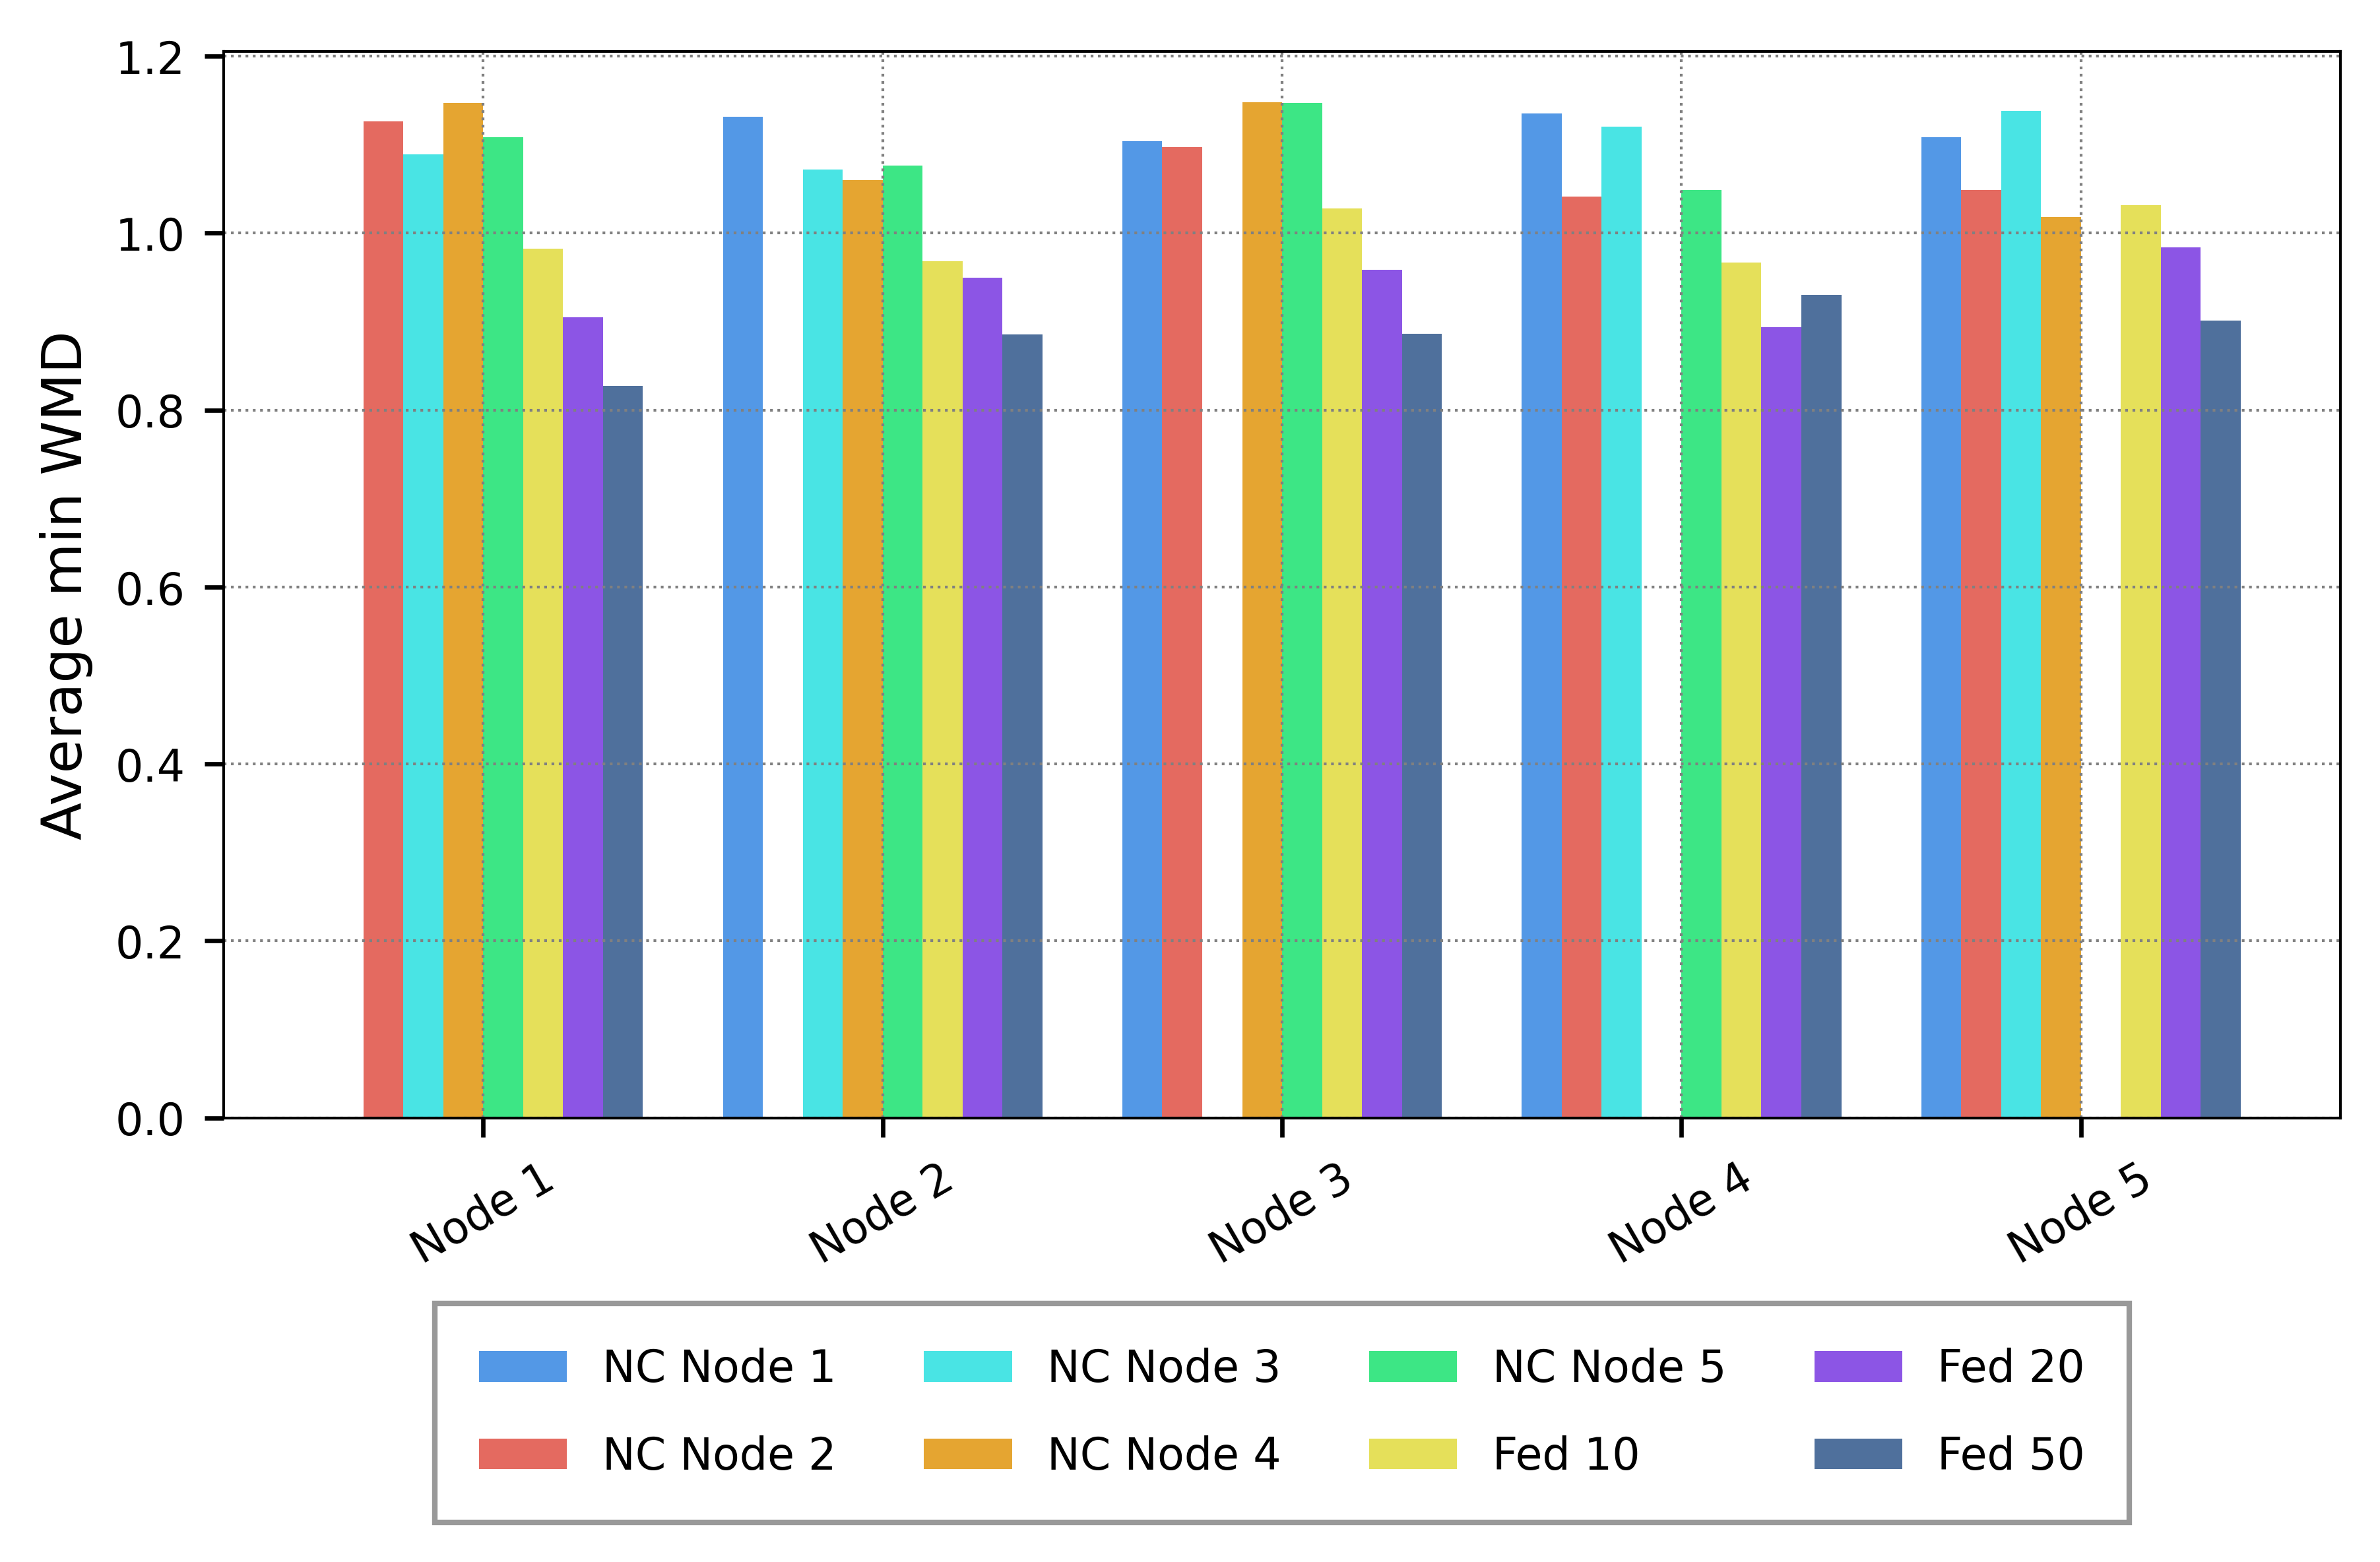

In [16]:
# creating the dataframe
df50 = pd.DataFrame(data = distances, 
                  index = index_values, 
                  columns = column_values)
# plot graph
plot_graph(df50)

#### Topn = 100

In [ ]:
n_words = 100
tfidf = True

distances = np.zeros((len(node_models), len(all_models)))

for idx_ref, ref_model in enumerate(node_models):
    this_topic_dst = []
    ref_topics = [el[1].split(', ') for el in TMmodel(ref_model.joinpath('TMmodel')).get_tpc_word_descriptions(n_words=n_words, tfidf=tfidf)]
    for idx_comp, comp_model in enumerate(all_models):
        comp_topics = [el[1].split(', ') for el in TMmodel(comp_model.joinpath('TMmodel')).get_tpc_word_descriptions(n_words=n_words, tfidf=tfidf)]
        all_dist = np.zeros((len(ref_topics), len(comp_topics)))
        for idx1,tpc1 in enumerate(ref_topics):
            for idx2,tpc2 in enumerate(comp_topics):
                all_dist[idx1,idx2] = model.wmdistance(tpc1[:n_words], tpc2[:n_words])
        distances[idx_ref, idx_comp] = np.mean(np.min(all_dist,axis=1))

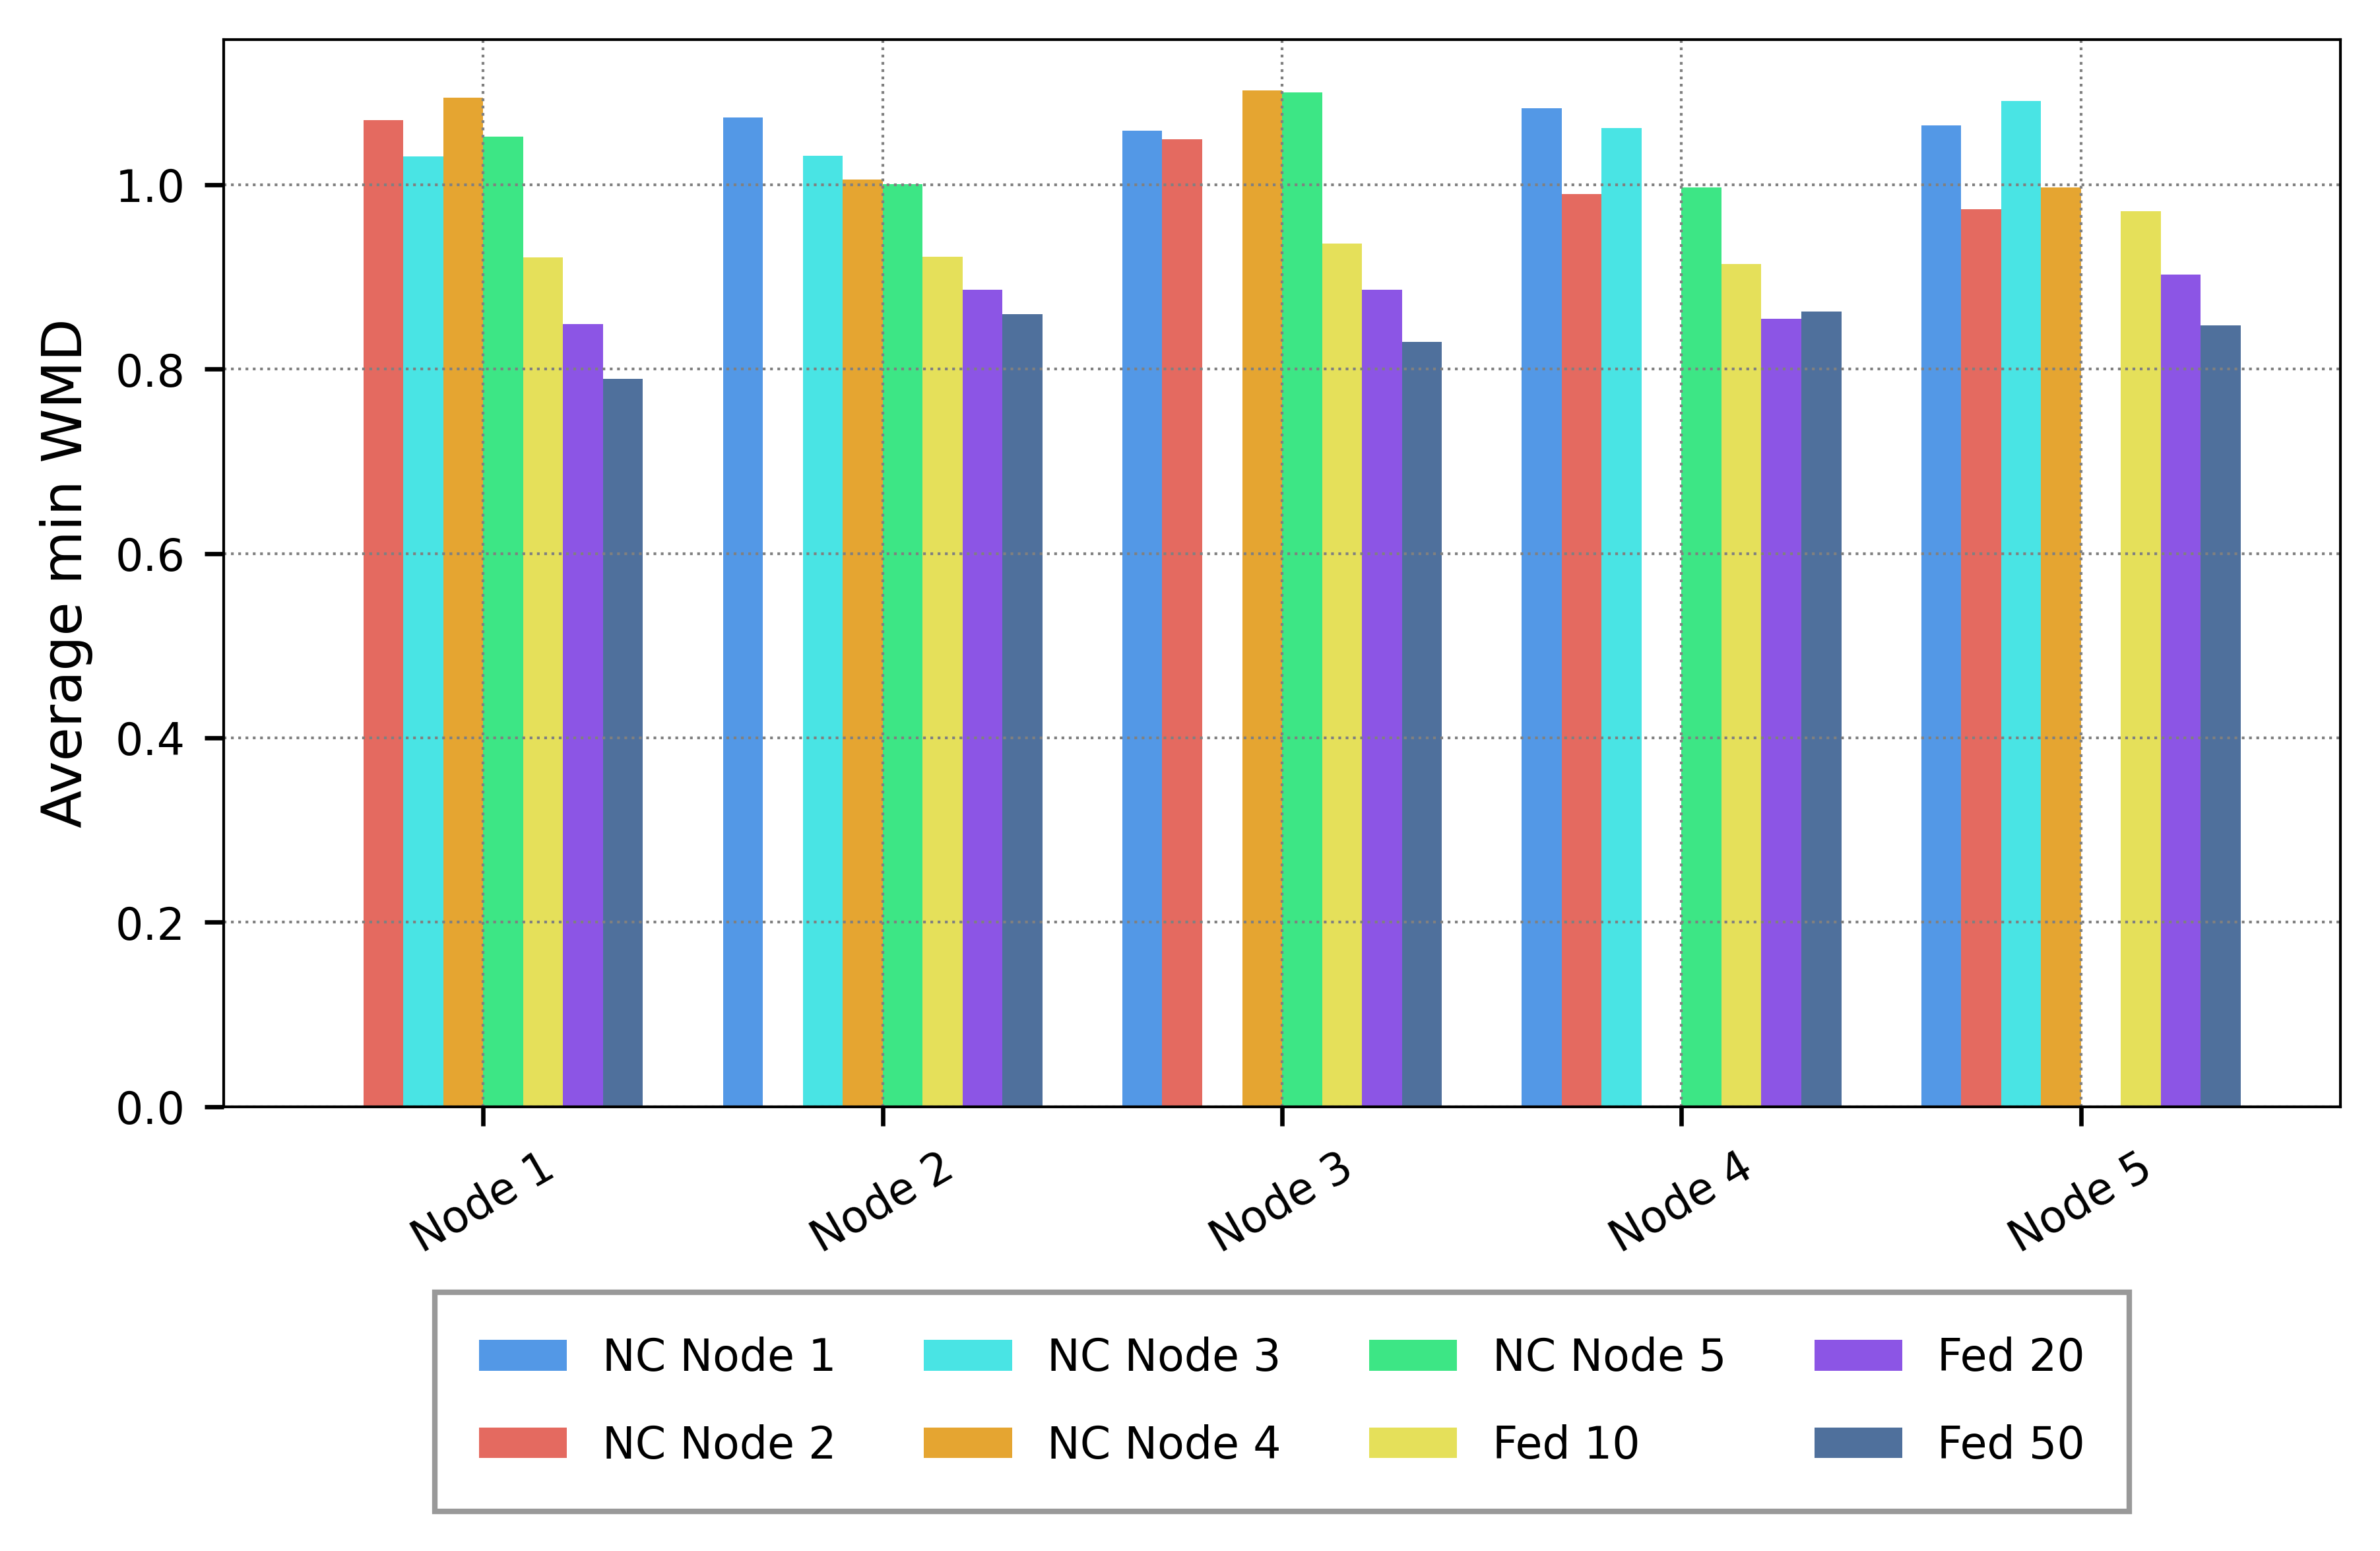

In [18]:
# creating the dataframe
df100 = pd.DataFrame(data = distances, 
                  index = index_values, 
                  columns = column_values)
# plot graph
plot_graph(df100)

#### Topn = 200

In [ ]:
n_words = 200
tfidf = True

distances = np.zeros((len(node_models), len(all_models)))

for idx_ref, ref_model in enumerate(node_models):
    this_topic_dst = []
    ref_topics = [el[1].split(', ') for el in TMmodel(ref_model.joinpath('TMmodel')).get_tpc_word_descriptions(n_words=n_words, tfidf=tfidf)]
    for idx_comp, comp_model in enumerate(all_models):
        comp_topics = [el[1].split(', ') for el in TMmodel(comp_model.joinpath('TMmodel')).get_tpc_word_descriptions(n_words=n_words, tfidf=tfidf)]
        all_dist = np.zeros((len(ref_topics), len(comp_topics)))
        for idx1,tpc1 in enumerate(ref_topics):
            for idx2,tpc2 in enumerate(comp_topics):
                all_dist[idx1,idx2] = model.wmdistance(tpc1[:n_words], tpc2[:n_words])
        distances[idx_ref, idx_comp] = np.mean(np.min(all_dist,axis=1))

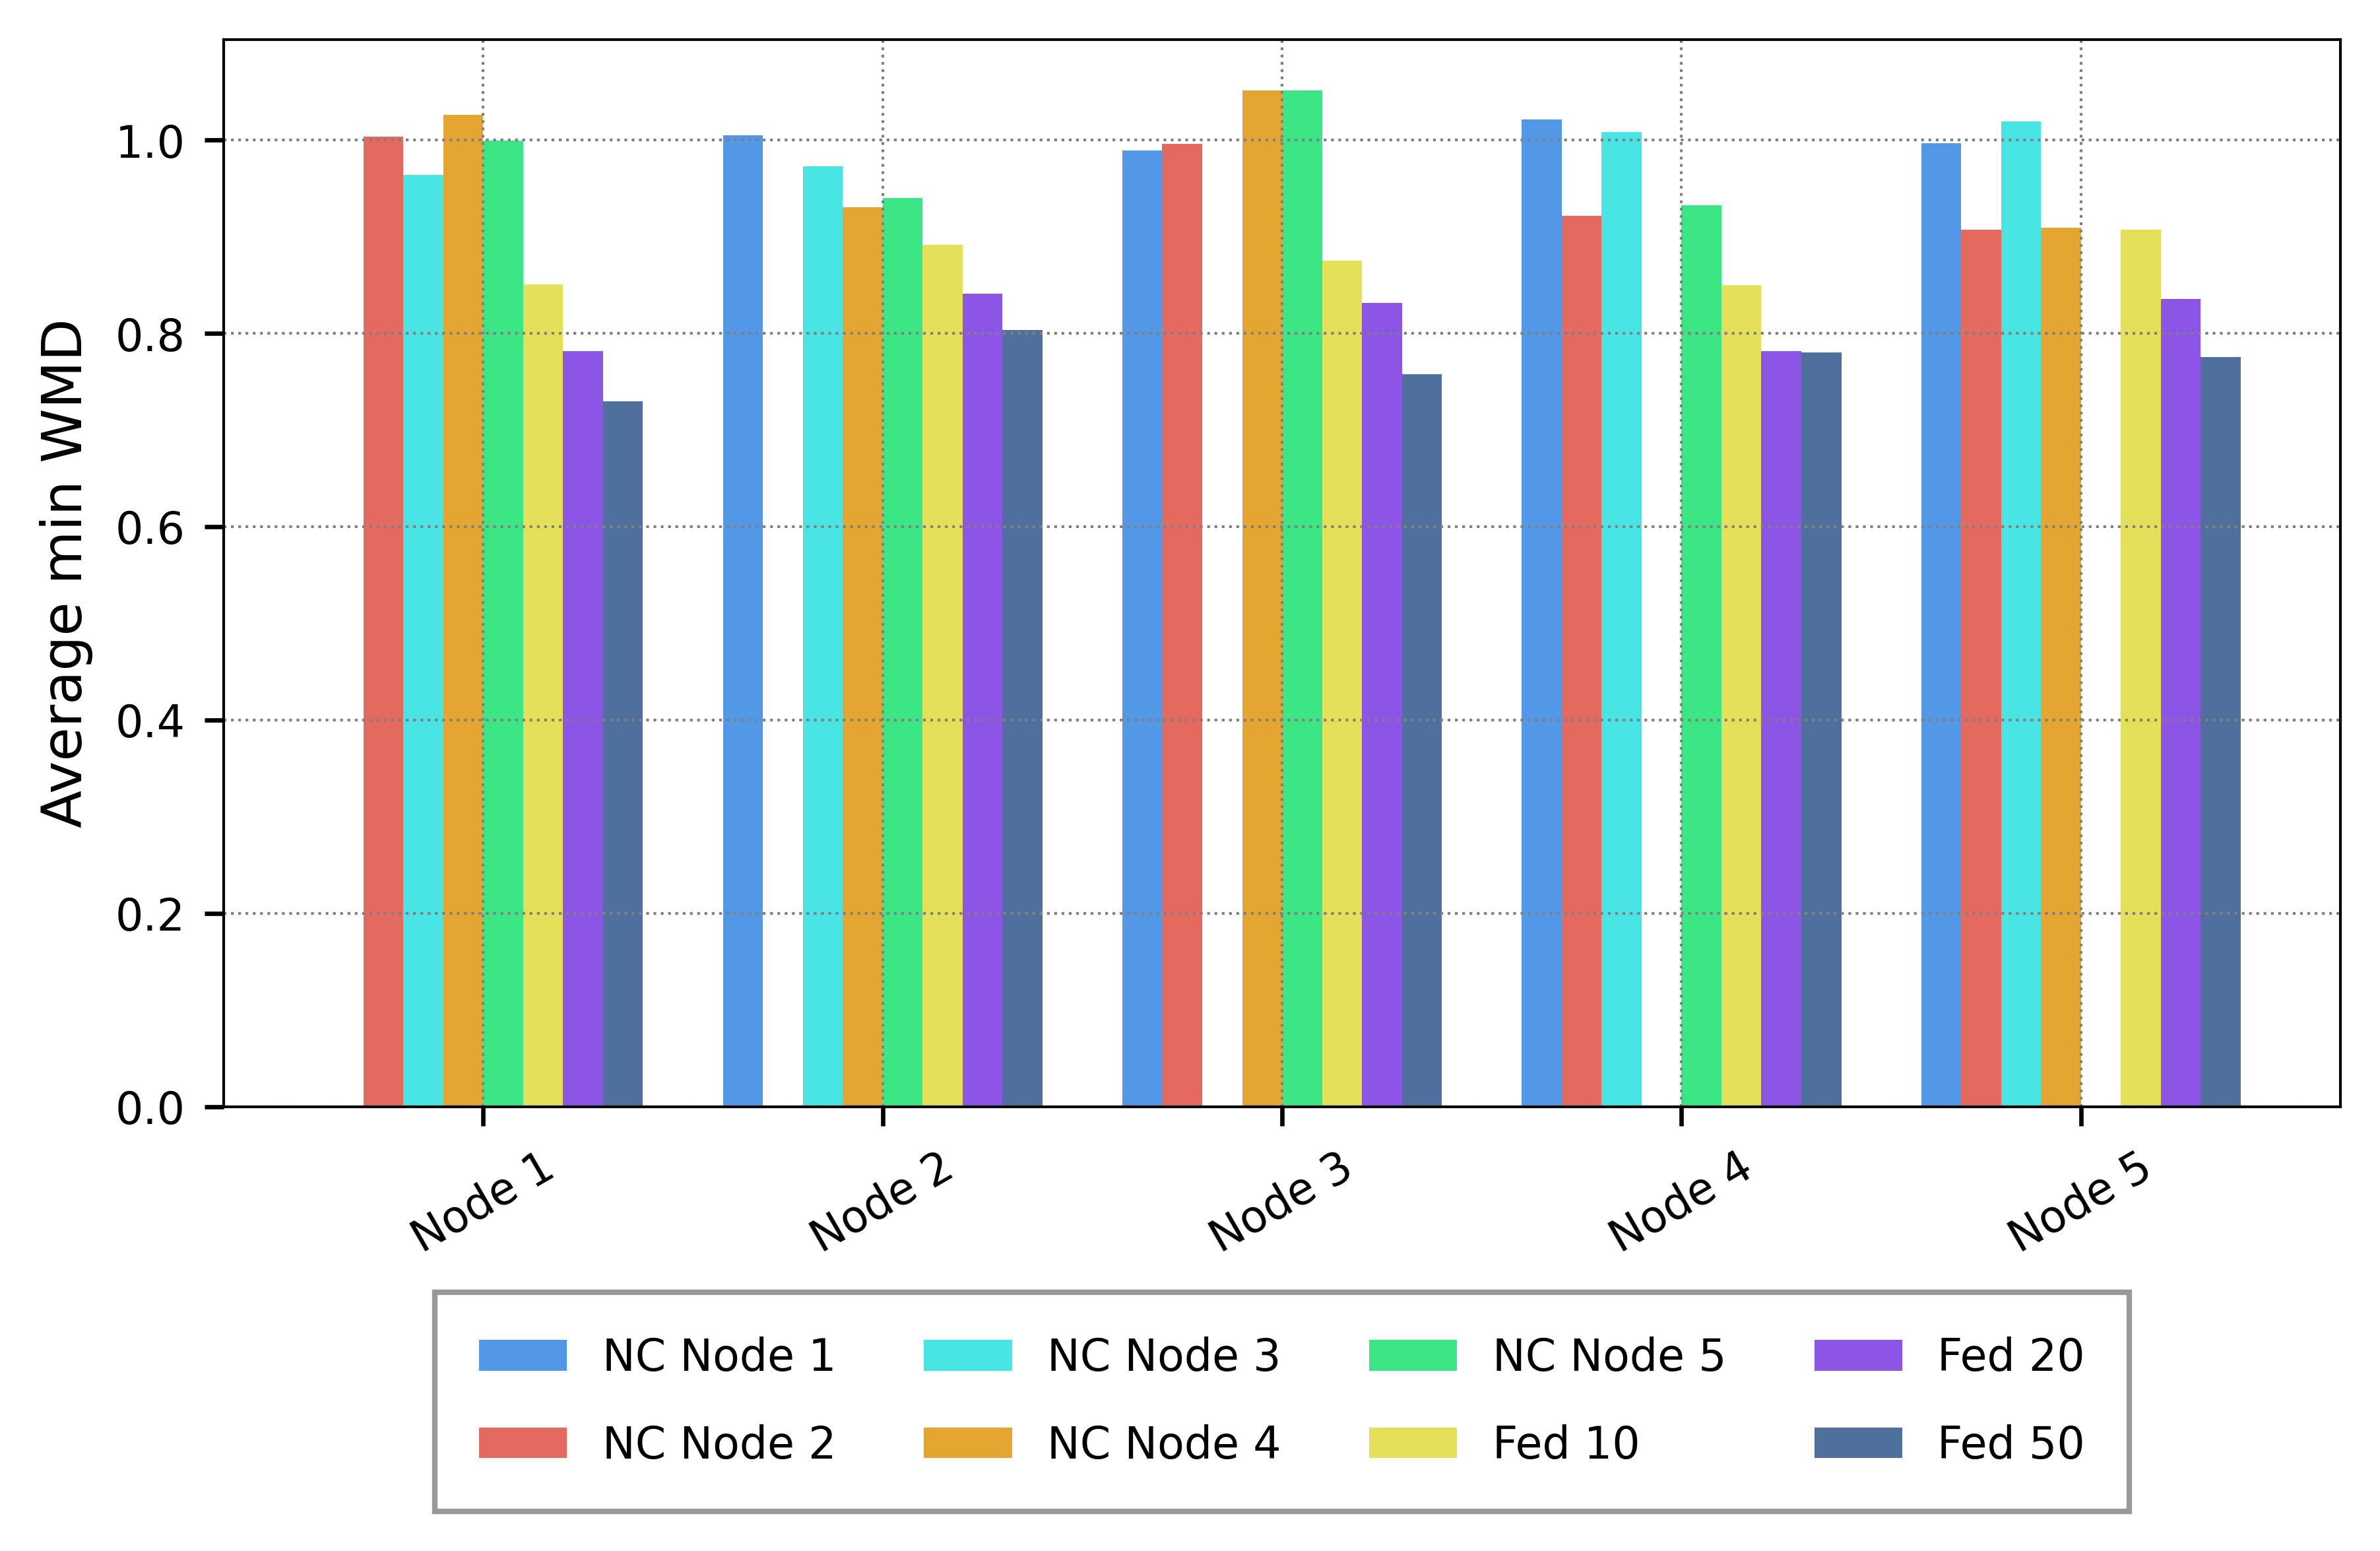

In [20]:
# creating the dataframe
df200 = pd.DataFrame(data = distances, 
                  index = index_values, 
                  columns = column_values)
# plot graph
plot_graph(df200)

#### Topn = 300

In [ ]:
n_words = 300
tfidf = True

distances = np.zeros((len(node_models), len(all_models)))

for idx_ref, ref_model in enumerate(node_models):
    this_topic_dst = []
    ref_topics = [el[1].split(', ') for el in TMmodel(ref_model.joinpath('TMmodel')).get_tpc_word_descriptions(n_words=n_words, tfidf=tfidf)]
    for idx_comp, comp_model in enumerate(all_models):
        comp_topics = [el[1].split(', ') for el in TMmodel(comp_model.joinpath('TMmodel')).get_tpc_word_descriptions(n_words=n_words, tfidf=tfidf)]
        all_dist = np.zeros((len(ref_topics), len(comp_topics)))
        for idx1,tpc1 in enumerate(ref_topics):
            for idx2,tpc2 in enumerate(comp_topics):
                all_dist[idx1,idx2] = model.wmdistance(tpc1[:n_words], tpc2[:n_words])
        distances[idx_ref, idx_comp] = np.mean(np.min(all_dist,axis=1))

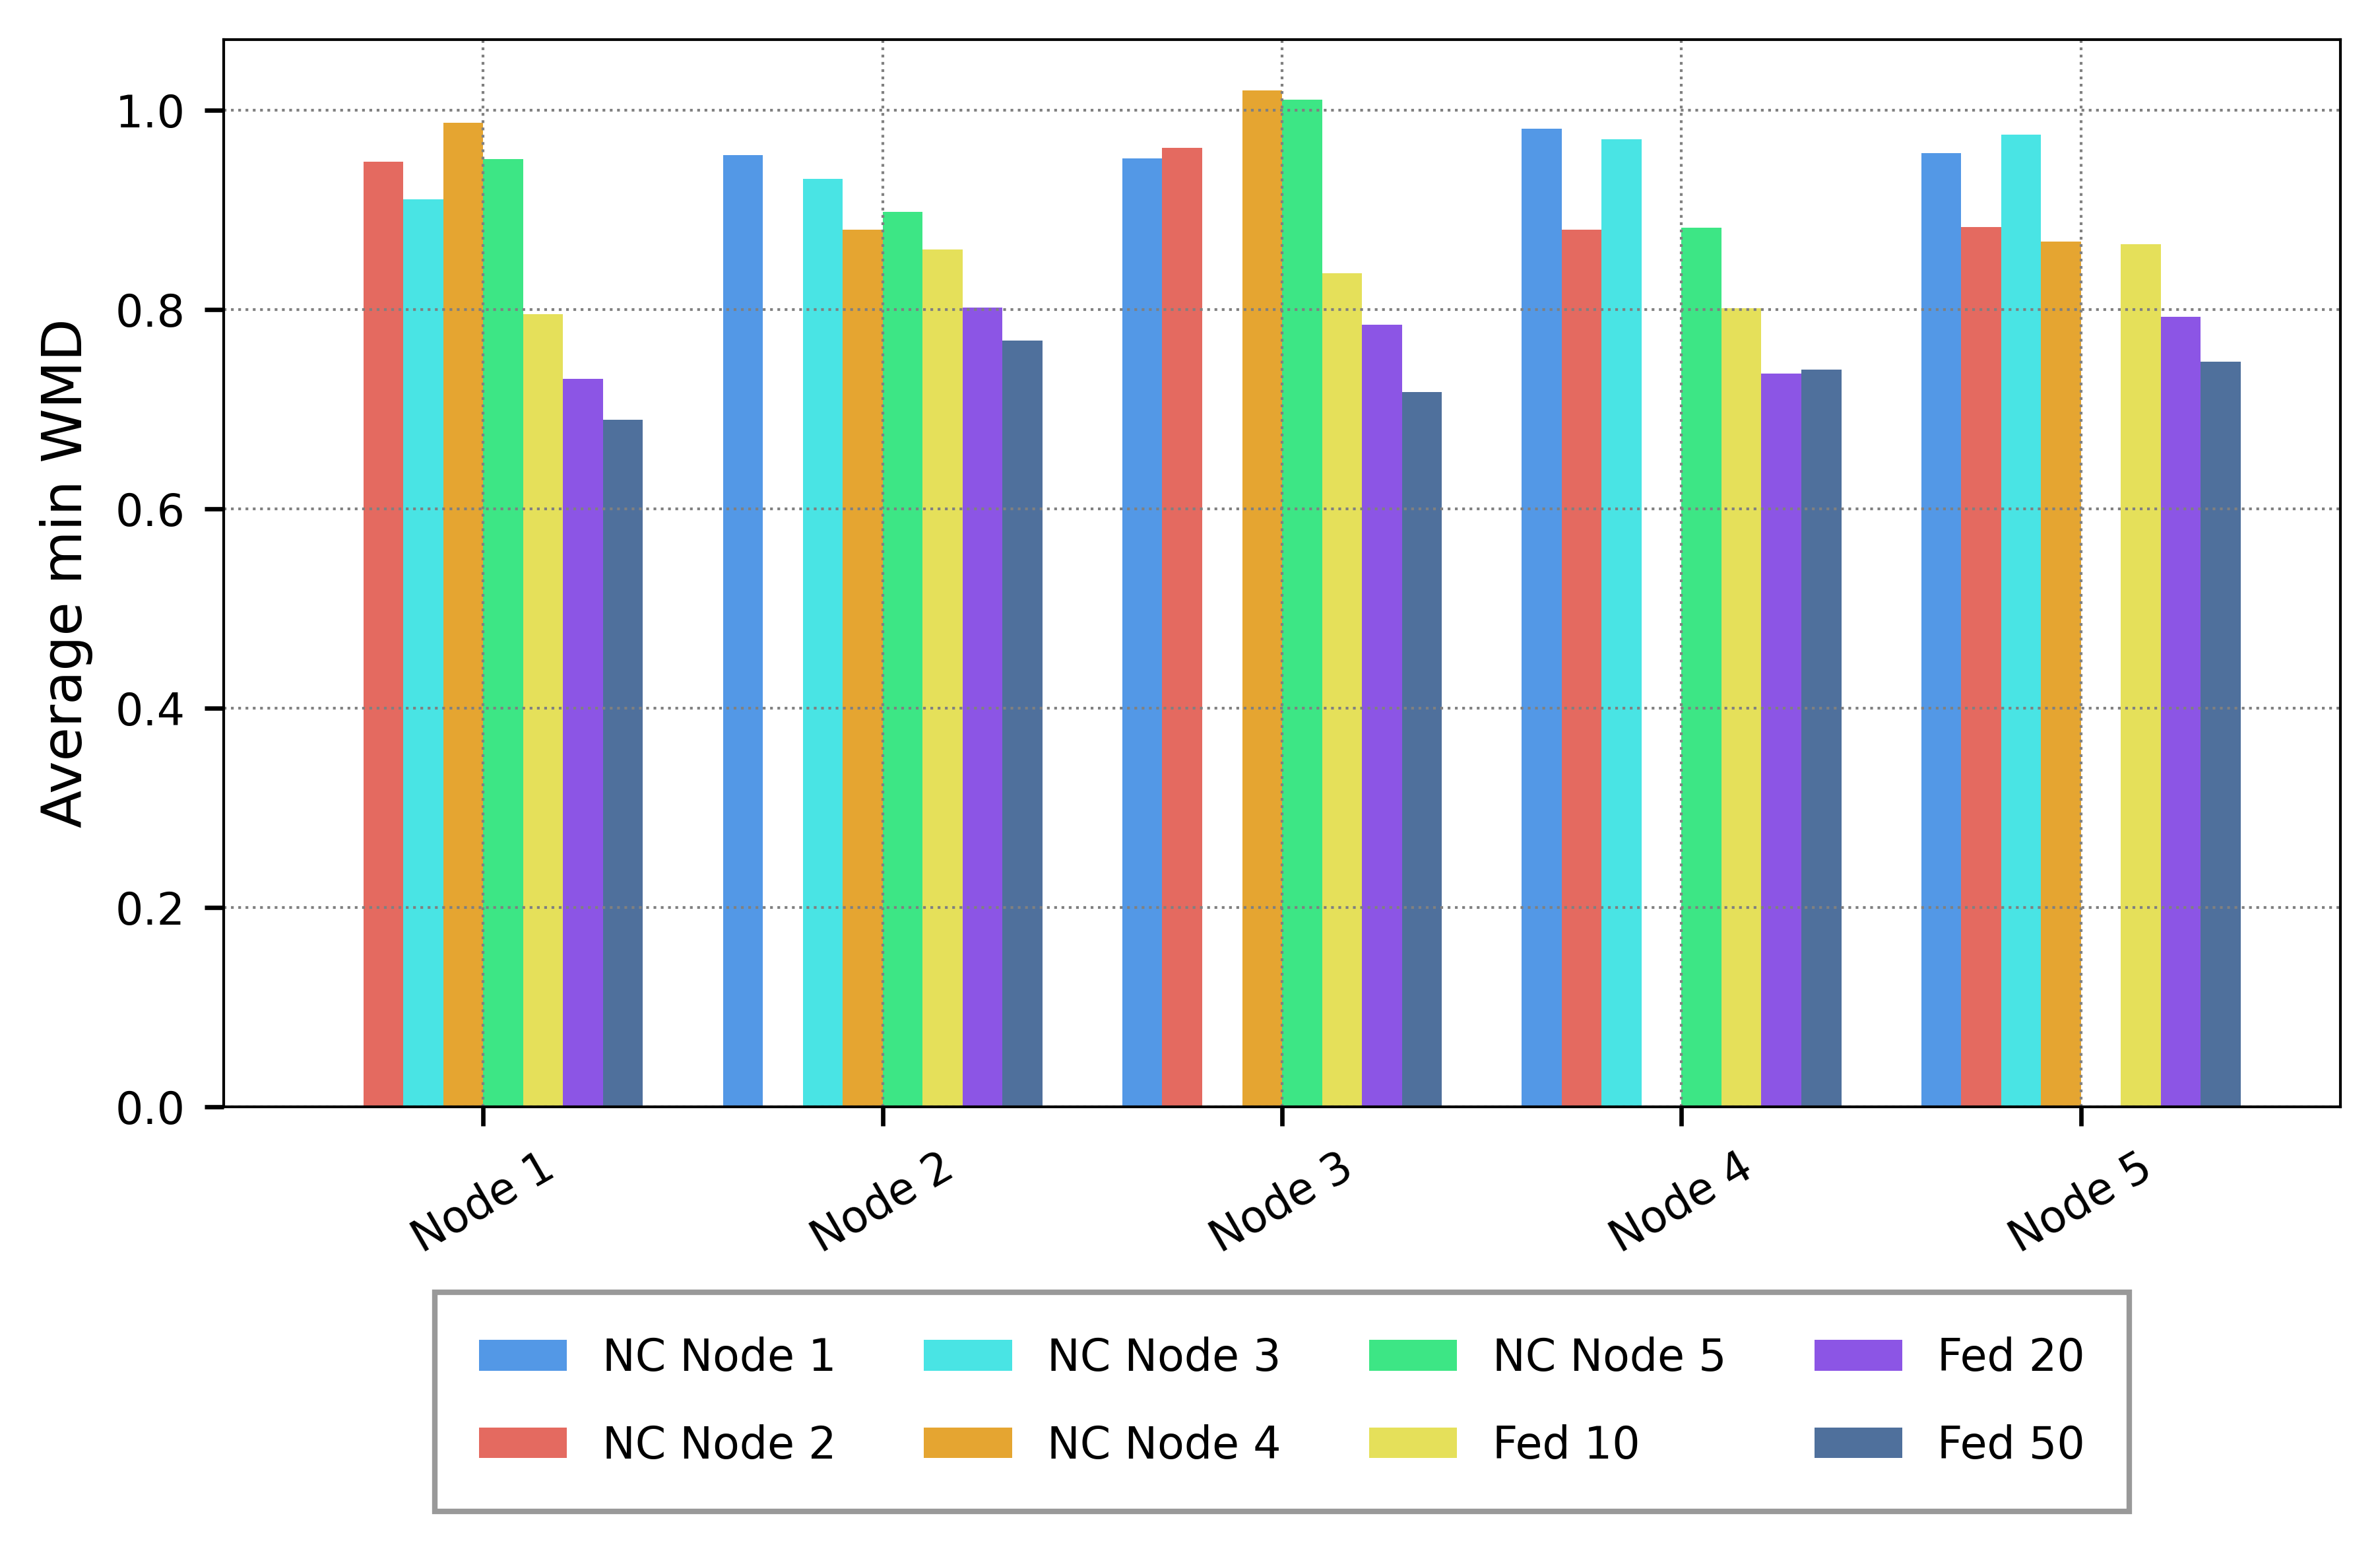

In [22]:
# creating the dataframe
df300 = pd.DataFrame(data = distances, 
                  index = index_values, 
                  columns = column_values)
# plot graph
plot_graph(df300)